<a href="https://colab.research.google.com/github/HunterBushnell/LUT_Neonate/blob/main/LUT_NeonateP0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install
!pip install neuron==8.2.2
!pip install bmtk==1.0.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.6/743.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
# Download Files

import os

if os.path.basename(os.getcwd())!='LUT_Neonate':
  !git clone https://github.com/HunterBushnell/LUT_Neonate
  %cd LUT_Neonate/
else:
  print('Mod files have already been downloaded.')
%ls

Cloning into 'LUT_Neonate'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 389 (delta 95), reused 142 (delta 87), pack-reused 237
Receiving objects: 100% (389/389), 3.14 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (187/187), done.
/content/LUT_Neonate
biophys_components/  images/               notes/           plotting.pkl
Blad_spikes.csv      jsons/                output/          plotting.py
build_network.py     LUT_Neonate.ipynb     P0/              README.md
error_logs/          LUT_NeonateP0.ipynb   P14/             requirements.txt
EUS_spikes.csv       LUT_NeonateP14.ipynb  P21/             run_bionet.py
feedback_loop.py     LUT_NeonateP21.ipynb  P3/              run.sh
generate_input.py    LUT_NeonateP3.ipynb   PAG_spikes.csv   synapses.py
graphs/              network/              plot_results.py


In [ ]:
# Compile Files

import os
# move to the mechanisms folder
%cd biophys_components/mechanisms/
os.system("rm -rf x86_64") # deletes x86_64 if its there
%ls # just to make sure its gone
print(os.system('nrnivmodl modfiles')) # compile modfiles. Return 0 for success, 1 for failure.
%ls # check to make sure the folder is there now
%cd ../..
%ls

/content/LUT_Neonate/biophys_components/mechanisms
filess  modfiles/
0
filess  modfiles/  x86_64/
/content/LUT_Neonate
biophys_components/  images/               notes/           plotting.pkl
Blad_spikes.csv      jsons/                output/          plotting.py
build_network.py     LUT_Neonate.ipynb     P0/              README.md
error_logs/          LUT_NeonateP0.ipynb   P14/             requirements.txt
EUS_spikes.csv       LUT_NeonateP14.ipynb  P21/             run_bionet.py
feedback_loop.py     LUT_NeonateP21.ipynb  P3/              run.sh
generate_input.py    LUT_NeonateP3.ipynb   PAG_spikes.csv   synapses.py
graphs/              network/              plot_results.py


In [ ]:
# Build Network

import numpy as np
from bmtk.builder.networks import NetworkBuilder
import math
import random

random.seed(42)
output_dir='network'

#######################################################################
##################### Create the cells ################################
#######################################################################
print("\nCreating Cells")

# Build the main network
net = NetworkBuilder('LUT')

# Specify number of cells in each population #

numBladaff  = 10
numPAGaff   = 10
#numEUSaff   = 10
numIND      = 10
numHypo     = 10
#numINmplus  = 10
#numINmminus = 10
numPGN      = 10
numFB       = 10
numIMG      = 10
numMPG      = 10
#numEUSmn    = 10
#numBladmn   = 10
# Create the nodes ----------------------------------------
net.add_nodes(N=numBladaff, level='high',pop_name='Bladaff',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')
net.add_nodes(N=numPAGaff, pop_name='PAGaff',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')
# net.add_nodes(N=numEUSaff, level='high',pop_name='EUSaff',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')
net.add_nodes(N=numIND, pop_name='IND',model_type='biophysical',model_template='hoc:IND',morphology='blank.swc')
net.add_nodes(N=numHypo, pop_name='Hypo',model_type='biophysical',model_template='hoc:HYPO',morphology='blank.swc')
# net.add_nodes(N=numINmplus, pop_name='INmplus',model_type='biophysical',model_template='hoc:INM',morphology='blank.swc')
# net.add_nodes(N=numINmminus, pop_name='INmminus',model_type='biophysical',model_template='hoc:INM',morphology='blank.swc')
net.add_nodes(N=numPGN, level='low', pop_name='PGN',model_type='biophysical',model_template='hoc:PGN',morphology='blank.swc')
net.add_nodes(N=numFB, pop_name='FB',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')
net.add_nodes(N=numIMG, pop_name='IMG',model_type='biophysical',model_template='hoc:IMG',morphology='blank.swc')
net.add_nodes(N=numMPG, pop_name='MPG',model_type='biophysical',model_template='hoc:MPG',morphology='blank.swc')
# net.add_nodes(N=numEUSmn, pop_name='EUSmn',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')
# net.add_nodes(N=numBladmn, pop_name='Bladmn',model_type='biophysical',model_template='hoc:PUD',morphology='blank.swc')

##################################################################################
####################### Connect the cells ########################################
##################################################################################
print("\nConnecting Cells")

# Connectivity function
# To use this function, the number of cells in the source population must be the same
# as the number of cells in the target population.
def one_to_one(source, target):
    sid = source.node_id
    tid = target.node_id
    source_name = source['pop_name']
    target_name = target['pop_name']
    # if source_name=='EUSaff':
    #     sid = sid-(numBladaff)
    if source_name=='PAGaff':
        sid = sid-(numBladaff)
    if source_name=='IND':
        sid = sid-(numBladaff+numPAGaff)
    if source_name=='Hypo':
        sid = sid-(numBladaff+numPAGaff+numIND)
    # if source_name=='INmplus':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if source_name=='INmminus':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    if source_name=='PGN':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo)
    if source_name=='FB':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN)
    if source_name=='IMG':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB)
    if source_name=='MPG':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB+numIMG)
    # if source_name=='EUSmn':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if source_name=='Bladmn':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    # if target_name=='EUSaff':
        # tid = tid-(numBladaff)
    if target_name=='PAGaff':
        tid = tid-(numBladaff)
    if target_name=='IND':
        tid = tid-(numBladaff+numPAGaff)
    if target_name=='Hypo':
        tid = tid-(numBladaff+numPAGaff+numIND)
    # if target_name=='INmplus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if target_name=='INmminus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    if target_name=='PGN':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo)
    if target_name=='FB':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN)
    if target_name=='IMG':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB)
    if target_name=='MPG':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB+numIMG)
    # if target_name=='EUSmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if target_name=='Bladmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    if sid == tid:
        print("connecting {} cell {} to {} cell {}".format(source_name,sid,target_name,tid))
        tmp_nsyn = 1
    else:
        return None

    return tmp_nsyn


def percent_connector(source,target,percent):
    """
    For connections where types don't have the same number of cells
    And positions are undefined for one type
    """
    sid = source.node_id
    tid = target.node_id
    source_name = source['pop_name']
    target_name = target['pop_name']

    # if source_name=='EUSaff':
    #     sid = sid-(numBladaff)
    if source_name=='PAGaff':
        sid = sid-(numBladaff)
    if source_name=='IND':
        sid = sid-(numBladaff+numPAGaff)
    if source_name=='Hypo':
        sid = sid-(numBladaff+numPAGaff+numIND)
    # if source_name=='INmplus':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if source_name=='INmminus':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    if source_name=='PGN':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo)
    if source_name=='FB':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN)
    if source_name=='IMG':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB)
    if source_name=='MPG':
        sid = sid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB+numIMG)
    # if source_name=='EUSmn':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if source_name=='Bladmn':
        # sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    # if target_name=='EUSaff':
        # tid = tid-(numBladaff)
    if target_name=='PAGaff':
        tid = tid-(numBladaff)
    if target_name=='IND':
        tid = tid-(numBladaff+numPAGaff)
    if target_name=='Hypo':
        tid = tid-(numBladaff+numPAGaff+numIND)
    # if target_name=='INmplus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if target_name=='INmminus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    if target_name=='PGN':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo)
    if target_name=='FB':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN)
    if target_name=='IMG':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB)
    if target_name=='MPG':
        tid = tid-(numBladaff+numPAGaff+numIND+numHypo+numPGN+numFB+numIMG)
    # if target_name=='EUSmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if target_name=='Bladmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    # if source_name=='EUSaff':
    #     sid = sid-(numBladaff)
    # if source_name=='PAGaff':
    #     sid = sid-(numBladaff+numEUSaff)
    # if source_name=='IND':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff)
    # if source_name=='Hypo':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND)
    # if source_name=='INmplus':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if source_name=='INmminus':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    # if source_name=='PGN':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus)
    # if source_name=='FB':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN)
    # if source_name=='IMG':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB)
    # if source_name=='MPG':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG)
    # if source_name=='EUSmn':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if source_name=='Bladmn':
    #     sid = sid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    # if target_name=='EUSaff':
    #     tid = tid-(numBladaff)
    # if target_name=='PAGaff':
    #     tid = tid-(numBladaff+numEUSaff)
    # if target_name=='IND':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff)
    # if target_name=='Hypo':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND)
    # if target_name=='INmplus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo)
    # if target_name=='INmminus':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus)
    # if target_name=='PGN':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus)
    # if target_name=='FB':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN)
    # if target_name=='IMG':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB)
    # if target_name=='MPG':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG)
    # if target_name=='EUSmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG)
    # if target_name=='Bladmn':
    #     tid = tid-(numBladaff+numEUSaff+numPAGaff+numIND+numHypo+numINmplus+numINmminus+numPGN+numFB+numIMG+numMPG+numEUSmn)

    if random.random() < (float(percent)/100):
        print("connecting {} cell {} to {} cell {}".format(source_name,sid,target_name,tid))
        return 1
    else:
        return 0

def conn_props(source,target,mu,sigma):
    """
    Simply add connection properties as normal
    https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/NetworkBuilder_Intro.ipynb
    Can also adjust weights before running the network.
    See https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/02_single_cell_syn.ipynb
    Section 5
    If done this way the function will need to be imported in the run script, consider refactoring?
    """

    #syn_weight = np.random.lognormal(mean=mu,sigma=sigma)
    syn_weight = mu

    return syn_weight,0,0.5


# Add connections -----------------------------------------

# Blad afferent --> INd (Grill et al. 2016)
conn = net.add_edges(source=net.nodes(pop_name='Bladaff'), target=net.nodes(pop_name='IND'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
				   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':1.0e-3,'sigma':1},
                    dtypes=[np.float, np.int32, np.float])

 # Blad afferent --> Hypogastric (Hou et al. 2014)
conn = net.add_edges(source=net.nodes(pop_name='Bladaff'), target=net.nodes(pop_name='Hypo'),
                    connection_rule=percent_connector,
                    connection_params={'percent':10.0},
                    target_sections=['somatic'],
                    delay=2.0,
                    distance_range=[0.0, 300.0],
                    dynamics_params='AMPA_ExcToExc.json',
                    model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                     rule=conn_props,
                     rule_params={'mu':12.0e-3,'sigma':1},
                     dtypes=[np.float, np.int32, np.float])

######## EUS afferent --> INd (Grill et al. 2016)
# conn = net.add_edges(source=net.nodes(pop_name='EUSaff'), target=net.nodes(pop_name='IND'),
#                    connection_rule=percent_connector,
#                    connection_params={'percent':100.0},
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='AMPA_ExcToExc.json',
#                    model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
#                     rule=conn_props,
#                     rule_params={'mu':1.0e-3,'sigma':1},
#                     dtypes=[np.float, np.int32, np.float])

# PAG afferent --> INd (Grill et al. 2016)
conn = net.add_edges(source=net.nodes(pop_name='PAGaff'), target=net.nodes(pop_name='IND'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':12.0e-3,'sigma':1},  # was 20.0e-3
                    dtypes=[np.float, np.int32, np.float])

# INd --> PGN (Grill et al. 2016)
conn = net.add_edges(source=net.nodes(pop_name='IND'), target=net.nodes(pop_name='PGN'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':9.0e-3,'sigma':1},
                    dtypes=[np.float, np.int32, np.float])

 # Hypogastric --> IMG (Beckel et al. 2015)
conn = net.add_edges(source=net.nodes(pop_name='Hypo'), target=net.nodes(pop_name='IMG'),
                    connection_rule=percent_connector,
                    connection_params={'percent':10.0},
                    target_sections=['somatic'],
                    delay=2.0,
                    distance_range=[0.0, 300.0],
                    dynamics_params='AMPA_ExcToExc.json',
                    model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                     rule=conn_props,
                     rule_params={'mu':12.0e-3,'sigma':1},
                     dtypes=[np.float, np.int32, np.float])

## STSP synapse ##
# # EUS afferent --> INm+ (Grill et al. 2016) **Low pass filter**
# conn = net.add_edges(source=net.nodes(pop_name='EUSaff'), target=net.nodes(pop_name='INmplus'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':100.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='stsp.json',
                   # model_template='Exp2Syn1_STSP')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':0.5,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

######## EUS afferent --> INm+(Grill et al. 2016)
# conn = net.add_edges(source=net.nodes(pop_name='EUSaff'), target=net.nodes(pop_name='INmplus'),
#                    connection_rule=percent_connector,
#                    connection_params={'percent':100.0},
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='AMPA_ExcToExc.json',
#                    model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
#                     rule=conn_props,
#                     rule_params={'mu':16.5e-3,'sigma':1},
#                     dtypes=[np.float, np.int32, np.float])
# PAG afferent --> INm+ (Source?)
# Using this connection instead of synaptic depression for low pass filtering
# conn = net.add_edges(source=net.nodes(pop_name='PAGaff'), target=net.nodes(pop_name='PGN'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':100.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='AMPA_ExcToExc.json',
                   # model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':11.0e-3,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

######## EUS afferent --> INm-(Grill et al. 2016)
# conn = net.add_edges(source=net.nodes(pop_name='EUSaff'), target=net.nodes(pop_name='INmminus'),
#                    connection_rule=percent_connector,
#                    connection_params={'percent':100.0},
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='AMPA_ExcToExc.json',
#                    model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
#                     rule=conn_props,
#                     rule_params={'mu':16.0e-3,'sigma':1},
#                     dtypes=[np.float, np.int32, np.float])

######## INm+ --> PGN (Grill et al. 2016)
# conn = net.add_edges(source=net.nodes(pop_name='INmplus'), target=net.nodes(pop_name='PGN'),
#                    cconnection_rule=percent_connector,
#                    connection_params={'percent':10.0},
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='AMPA_ExcToExc.json',
#                    model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
#                     rule=conn_props,
#                     rule_params={'mu':1.0e-3,'sigma':1},
#                     dtypes=[np.float, np.int32, np.float])

######## INm- --> PGN (Grill et al. 2016)
# conn = net.add_edges(source=net.nodes(pop_name='INmminus'), target=net.nodes(pop_name='PGN'),
#                    connection_rule=percent_connector,
#                    connection_params={'percent':10.0},
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='GABA_InhToExc.json',
#                    model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
#                     rule=conn_props,
#                     rule_params={'mu':20.0e-3,'sigma':1},
#                     dtypes=[np.float, np.int32, np.float])

# PGN --> MPG (Beckel et al. 2015)
conn = net.add_edges(source=net.nodes(pop_name='PGN'), target=net.nodes(pop_name='MPG'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':12.0e-3,'sigma':1},
                    dtypes=[np.float, np.int32, np.float])

# PGN --> FB (Grill et al. 2016)
conn = net.add_edges(source=net.nodes(pop_name='PGN'), target=net.nodes(pop_name='FB'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':16.0e-3,'sigma':1}, #was 12.0e-3
                    dtypes=[np.float, np.int32, np.float])

# FB --> INd (Grill et al. 2016)
conn = net.add_edges(source=net.nodes(pop_name='FB'), target=net.nodes(pop_name='IND'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='GABA_InhToInh.json',
                   model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    rule=conn_props,
                    rule_params={'mu':20.0e-3,'sigma':1},       # was 12.0e-3
                    dtypes=[np.float, np.int32, np.float])

# # MPG --> Bladder MN (Beckel et al. 2015)
# conn = net.add_edges(source=net.nodes(pop_name='MPG'), target=net.nodes(pop_name='Bladmn'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':10.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='AMPA_ExcToExc.json',
                   # model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':16.0e-3,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

# # IMG --> Bladder MN (Beckel et al. 2015)
# conn = net.add_edges(source=net.nodes(pop_name='IMG'), target=net.nodes(pop_name='Bladmn'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':10.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='GABA_InhToInh.json',
                   # model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':10.0e-3,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

# PAG aff --> Hypogastric (de Groat, et al. 2015)
conn = net.add_edges(source=net.nodes(pop_name='PAGaff'), target=net.nodes(pop_name='Hypo'),
                    connection_rule=percent_connector,
                    connection_params={'percent':100.0},
                    target_sections=['somatic'],
                    delay=2.0,
                    distance_range=[0.0, 300.0],
                    dynamics_params='GABA_InhToInh.json',
                    model_template='Exp2Syn')

conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                     rule=conn_props,
                     rule_params={'mu':12.0e-3,'sigma':1},
                     dtypes=[np.float, np.int32, np.float])

# PAG aff --> EUS MN (Shefchyk et al. 2001)
# conn = net.add_edges(source=net.nodes(pop_name='PAGaff'), target=net.nodes(pop_name='EUSmn'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':100.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='GABA_InhToInh.json',
                   # model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':12.0e-3,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

# EUS afferent --> EUS MN (Beckel et al. 2015)
# conn = net.add_edges(source=net.nodes(pop_name='EUSaff'), target=net.nodes(pop_name='EUSmn'),
                   # connection_rule=percent_connector,
                   # connection_params={'percent':100.0},
                   # target_sections=['somatic'],
                   # delay=2.0,
                   # distance_range=[0.0, 300.0],
                   # dynamics_params='AMPA_ExcToExc.json',
                   # model_template='Exp2Syn')

# conn.add_properties(names=['syn_weight', 'sec_id', 'sec_x'],
                    # rule=conn_props,
                    # rule_params={'mu':12.0e-3,'sigma':1},
                    # dtypes=[np.float, np.int32, np.float])

# Connect virtual cells to EUS, Bladder, and PAG/PMC
Blad_aff_virt = NetworkBuilder('Blad_aff_virt') # Virtual cells delivering input to Bladder
# EUS_aff_virt = NetworkBuilder('EUS_aff_virt')   # Virtual cells delivering input to EUS
PAG_aff_virt = NetworkBuilder('PAG_aff_virt')   # Virtual cells delivering input to PAG/PMC

Blad_aff_virt.add_nodes(N=numBladaff, pop_name = 'Blad_aff_virt', model_type='virtual', potential='exc')
# EUS_aff_virt.add_nodes(N=numEUSaff, pop_name = 'EUS_aff_virt', model_type='virtual', potential='exc')
PAG_aff_virt.add_nodes(N=numPAGaff, pop_name = 'PAG_aff_virt', model_type='virtual', potential='exc')

Blad_aff_virt.add_edges(source=Blad_aff_virt.nodes(), target=net.nodes(pop_name='Bladaff'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   syn_weight=12.0e-03,
                   target_sections=['somatic'],
				   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')


# EUS_aff_virt.add_edges(source=EUS_aff_virt.nodes(), target=net.nodes(pop_name='EUSaff'),
#                    connection_rule=percent_connector,
#                    connection_params={'percent':100.0},
#                    syn_weight=12.0e-03,
#                    target_sections=['somatic'],
#                    delay=2.0,
#                    distance_range=[0.0, 300.0],
#                    dynamics_params='AMPA_ExcToExc.json',
#                    model_template='Exp2Syn')

PAG_aff_virt.add_edges(source=PAG_aff_virt.nodes(), target=net.nodes(pop_name='PAGaff'),
                   connection_rule=percent_connector,
                   connection_params={'percent':100.0},
                   syn_weight=20.0e-03,
                   target_sections=['somatic'],
                   delay=2.0,
                   distance_range=[0.0, 300.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='Exp2Syn')

####################################################################################
########################## Build and save network ##################################
####################################################################################

print("\nBuilding network and saving to directory \"" + output_dir + "\"")
net.build()
Blad_aff_virt.build()
# EUS_aff_virt.build()
PAG_aff_virt.build()

net.save_nodes(output_dir=output_dir)
net.save_edges(output_dir=output_dir)

Blad_aff_virt.save_nodes(output_dir=output_dir)
Blad_aff_virt.save_edges(output_dir=output_dir)

# EUS_aff_virt.save_nodes(output_dir=output_dir)
# EUS_aff_virt.save_edges(output_dir=output_dir)

PAG_aff_virt.save_nodes(output_dir=output_dir)
PAG_aff_virt.save_edges(output_dir=output_dir)

print("Done")


Creating Cells

Connecting Cells

Building network and saving to directory "network"
connecting Bladaff cell 0 to IND cell 0
connecting Bladaff cell 0 to IND cell 1
connecting Bladaff cell 0 to IND cell 2
connecting Bladaff cell 0 to IND cell 3
connecting Bladaff cell 0 to IND cell 4
connecting Bladaff cell 0 to IND cell 5
connecting Bladaff cell 0 to IND cell 6
connecting Bladaff cell 0 to IND cell 7
connecting Bladaff cell 0 to IND cell 8
connecting Bladaff cell 0 to IND cell 9
connecting Bladaff cell 1 to IND cell 0
connecting Bladaff cell 1 to IND cell 1
connecting Bladaff cell 1 to IND cell 2
connecting Bladaff cell 1 to IND cell 3
connecting Bladaff cell 1 to IND cell 4
connecting Bladaff cell 1 to IND cell 5
connecting Bladaff cell 1 to IND cell 6
connecting Bladaff cell 1 to IND cell 7
connecting Bladaff cell 1 to IND cell 8
connecting Bladaff cell 1 to IND cell 9
connecting Bladaff cell 2 to IND cell 0
connecting Bladaff cell 2 to IND cell 1
connecting Bladaff cell 2 to IND c

<ipython-input-4-3ced5f12cc94>:268: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtypes=[np.float, np.int32, np.float])
<ipython-input-4-3ced5f12cc94>:283: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtypes=[np.float, np.int32, np.float])
<ipython-input-4-3ced5f12cc94>:313: DeprecationWarning: `np.float` is a deprecated alias for the b


connecting PAG_aff_virt cell 7 to PAGaff cell 1
connecting PAG_aff_virt cell 7 to PAGaff cell 2
connecting PAG_aff_virt cell 7 to PAGaff cell 3
connecting PAG_aff_virt cell 7 to PAGaff cell 4
connecting PAG_aff_virt cell 7 to PAGaff cell 5
connecting PAG_aff_virt cell 7 to PAGaff cell 6
connecting PAG_aff_virt cell 7 to PAGaff cell 7
connecting PAG_aff_virt cell 7 to PAGaff cell 8
connecting PAG_aff_virt cell 7 to PAGaff cell 9
connecting PAG_aff_virt cell 8 to PAGaff cell 0
connecting PAG_aff_virt cell 8 to PAGaff cell 1
connecting PAG_aff_virt cell 8 to PAGaff cell 2
connecting PAG_aff_virt cell 8 to PAGaff cell 3
connecting PAG_aff_virt cell 8 to PAGaff cell 4
connecting PAG_aff_virt cell 8 to PAGaff cell 5
connecting PAG_aff_virt cell 8 to PAGaff cell 6
connecting PAG_aff_virt cell 8 to PAGaff cell 7
connecting PAG_aff_virt cell 8 to PAGaff cell 8
connecting PAG_aff_virt cell 8 to PAGaff cell 9
connecting PAG_aff_virt cell 9 to PAGaff cell 0
connecting PAG_aff_virt cell 9 to PAGaf

2023-08-09 19:53:54,450 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2023-08-09 19:53:54,613 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2023-08-09 19:53:54,667 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2023-08-09 19:53:54,808 [INFO] Building virtual cell stimulations for Blad_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for Blad_spikes


2023-08-09 19:53:54,860 [INFO] Building virtual cell stimulations for EUS_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for EUS_spikes


2023-08-09 19:53:54,914 [INFO] Building virtual cell stimulations for PAG_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for PAG_spikes


2023-08-09 19:53:54,981 [INFO] Running simulation for 50000.000 ms with the time step 0.200 ms


INFO:NEURONIOUtils:Running simulation for 50000.000 ms with the time step 0.200 ms


2023-08-09 19:53:54,986 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2023-08-09 19:53:54,991 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2023-08-09 19:53:56,358 [INFO]     step:5000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:1000.00 ms


2023-08-09 19:53:56,365 [INFO] Timestep 0.0 to 1000.0 ms


INFO:NEURONIOUtils:Timestep 0.0 to 1000.0 ms


2023-08-09 19:53:56,368 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:53:56,371 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:53:56,374 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:53:56,377 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:53:56,380 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:53:56,383 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:53:56,395 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:53:56,397 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:53:56,401 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:53:56,404 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:53:56,408 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:53:56,410 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:53:56,413 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:53:56,416 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:53:56,418 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:53:56,437 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:53:56,440 [INFO] Volume = 0.0000 ml


INFO:NEURONIOUtils:Volume = 0.0000 ml


2023-08-09 19:53:56,446 [INFO] Pressure = 0.00 mmHg


INFO:NEURONIOUtils:Pressure = 0.00 mmHg


2023-08-09 19:53:56,448 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:53:58,110 [INFO]     step:10000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:2000.00 ms


2023-08-09 19:53:58,120 [INFO] Timestep 1000.0 to 2000.0 ms


INFO:NEURONIOUtils:Timestep 1000.0 to 2000.0 ms


2023-08-09 19:53:58,125 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:53:58,129 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:53:58,131 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:53:58,134 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:53:58,137 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:53:58,139 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:53:58,142 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:53:58,144 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:53:58,146 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:53:58,149 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:53:58,151 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:53:58,154 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:53:58,158 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:53:58,160 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:53:58,162 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:53:58,169 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:53:58,174 [INFO] Volume = 2.0833 ml


INFO:NEURONIOUtils:Volume = 2.0833 ml


2023-08-09 19:53:58,176 [INFO] Pressure = 0.00 mmHg


INFO:NEURONIOUtils:Pressure = 0.00 mmHg


2023-08-09 19:53:58,178 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:53:59,939 [INFO]     step:15000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:3000.00 ms


2023-08-09 19:53:59,952 [INFO] Timestep 2000.0 to 3000.0 ms


INFO:NEURONIOUtils:Timestep 2000.0 to 3000.0 ms


2023-08-09 19:53:59,956 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:53:59,961 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:53:59,963 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:53:59,966 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:53:59,969 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:53:59,971 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:53:59,973 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:53:59,977 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:53:59,979 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:53:59,982 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:53:59,984 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:53:59,986 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:53:59,988 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:53:59,991 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:53:59,993 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:00,001 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:00,004 [INFO] Volume = 4.1667 ml


INFO:NEURONIOUtils:Volume = 4.1667 ml


2023-08-09 19:54:00,007 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:00,009 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:01,632 [INFO]     step:20000 t_sim:4000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:4000.00 ms


2023-08-09 19:54:01,646 [INFO] Timestep 3000.0 to 4000.0 ms


INFO:NEURONIOUtils:Timestep 3000.0 to 4000.0 ms


2023-08-09 19:54:01,651 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:01,655 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:54:01,658 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:54:01,660 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:54:01,662 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:54:01,664 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:54:01,667 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:54:01,669 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:54:01,671 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:54:01,673 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:54:01,675 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:54:01,678 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:54:01,681 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:54:01,683 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:01,685 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:54:01,692 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:54:01,695 [INFO] Volume = 6.2500 ml


INFO:NEURONIOUtils:Volume = 6.2500 ml


2023-08-09 19:54:01,698 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:54:01,700 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:03,366 [INFO]     step:25000 t_sim:5000.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:5000.00 ms


2023-08-09 19:54:03,376 [INFO] Timestep 4000.0 to 5000.0 ms


INFO:NEURONIOUtils:Timestep 4000.0 to 5000.0 ms


2023-08-09 19:54:03,381 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:03,385 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:54:03,388 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:54:03,390 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:54:03,392 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:54:03,394 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:54:03,397 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:54:03,403 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:54:03,405 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:54:03,411 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:54:03,413 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:54:03,415 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:54:03,417 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:54:03,419 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:03,424 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:54:03,432 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:54:03,437 [INFO] Volume = 8.3333 ml


INFO:NEURONIOUtils:Volume = 8.3333 ml


2023-08-09 19:54:03,439 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:54:03,441 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:05,615 [INFO]     step:30000 t_sim:6000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:6000.00 ms


2023-08-09 19:54:05,625 [INFO] Timestep 5000.0 to 6000.0 ms


INFO:NEURONIOUtils:Timestep 5000.0 to 6000.0 ms


2023-08-09 19:54:05,629 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:05,634 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:05,638 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:05,640 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:05,642 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:05,644 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:05,646 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:05,651 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:05,655 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:05,657 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:05,659 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:05,661 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:05,663 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:05,666 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:05,668 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:05,677 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:05,684 [INFO] Volume = 10.4167 ml


INFO:NEURONIOUtils:Volume = 10.4167 ml


2023-08-09 19:54:05,686 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:05,688 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:07,734 [INFO]     step:35000 t_sim:7000.00 ms


INFO:NEURONIOUtils:    step:35000 t_sim:7000.00 ms


2023-08-09 19:54:07,745 [INFO] Timestep 6000.0 to 7000.0 ms


INFO:NEURONIOUtils:Timestep 6000.0 to 7000.0 ms


2023-08-09 19:54:07,749 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:07,754 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:07,758 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:07,759 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:07,762 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:07,764 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:07,766 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:07,768 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:07,770 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:07,772 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:07,775 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:07,777 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:07,779 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:07,781 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:07,783 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:07,793 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:07,801 [INFO] Volume = 12.5000 ml


INFO:NEURONIOUtils:Volume = 12.5000 ml


2023-08-09 19:54:07,804 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:07,806 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:09,890 [INFO]     step:40000 t_sim:8000.00 ms


INFO:NEURONIOUtils:    step:40000 t_sim:8000.00 ms


2023-08-09 19:54:09,909 [INFO] Timestep 7000.0 to 8000.0 ms


INFO:NEURONIOUtils:Timestep 7000.0 to 8000.0 ms


2023-08-09 19:54:09,916 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:09,920 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:09,923 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:09,926 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:09,928 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:09,930 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:09,932 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:09,935 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:09,937 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:09,942 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:09,945 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:09,947 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:09,950 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:09,952 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:09,955 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:09,965 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:09,970 [INFO] Volume = 14.5833 ml


INFO:NEURONIOUtils:Volume = 14.5833 ml


2023-08-09 19:54:09,973 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:09,976 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:12,084 [INFO]     step:45000 t_sim:9000.00 ms


INFO:NEURONIOUtils:    step:45000 t_sim:9000.00 ms


2023-08-09 19:54:12,098 [INFO] Timestep 8000.0 to 9000.0 ms


INFO:NEURONIOUtils:Timestep 8000.0 to 9000.0 ms


2023-08-09 19:54:12,106 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:12,113 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:54:12,117 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:54:12,123 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:54:12,125 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:54:12,127 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:54:12,130 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:54:12,134 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:54:12,136 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:54:12,138 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:54:12,144 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:54:12,146 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:54:12,148 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:54:12,150 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:12,153 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:54:12,161 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:54:12,166 [INFO] Volume = 16.6667 ml


INFO:NEURONIOUtils:Volume = 16.6667 ml


2023-08-09 19:54:12,168 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:54:12,170 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:14,098 [INFO]     step:50000 t_sim:10000.00 ms


INFO:NEURONIOUtils:    step:50000 t_sim:10000.00 ms


2023-08-09 19:54:14,111 [INFO] Timestep 9000.0 to 10000.0 ms


INFO:NEURONIOUtils:Timestep 9000.0 to 10000.0 ms


2023-08-09 19:54:14,118 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:14,122 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:14,125 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:14,127 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:14,129 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:14,131 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:14,134 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:14,136 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:14,138 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:14,140 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:14,146 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:14,148 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:14,151 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:14,154 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:14,156 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:14,164 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:14,168 [INFO] Volume = 18.7500 ml


INFO:NEURONIOUtils:Volume = 18.7500 ml


2023-08-09 19:54:14,170 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:14,172 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:16,235 [INFO]     step:55000 t_sim:11000.00 ms


INFO:NEURONIOUtils:    step:55000 t_sim:11000.00 ms


2023-08-09 19:54:16,247 [INFO] Timestep 10000.0 to 11000.0 ms


INFO:NEURONIOUtils:Timestep 10000.0 to 11000.0 ms


2023-08-09 19:54:16,262 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:16,268 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:16,271 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:16,274 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:16,279 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:16,287 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:16,293 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:16,298 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:16,301 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:16,304 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:16,311 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:16,316 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:16,321 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:16,326 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:16,335 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:16,364 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:16,370 [INFO] Volume = 20.8333 ml


INFO:NEURONIOUtils:Volume = 20.8333 ml


2023-08-09 19:54:16,374 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:16,378 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:18,802 [INFO]     step:60000 t_sim:12000.00 ms


INFO:NEURONIOUtils:    step:60000 t_sim:12000.00 ms


2023-08-09 19:54:18,822 [INFO] Timestep 11000.0 to 12000.0 ms


INFO:NEURONIOUtils:Timestep 11000.0 to 12000.0 ms


2023-08-09 19:54:18,830 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:18,835 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:54:18,840 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:54:18,843 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:54:18,846 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:54:18,848 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:54:18,850 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:54:18,853 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:54:18,855 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:54:18,857 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:54:18,859 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:54:18,861 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:54:18,863 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:54:18,865 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:18,867 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:54:18,876 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:54:18,884 [INFO] Volume = 22.9167 ml


INFO:NEURONIOUtils:Volume = 22.9167 ml


2023-08-09 19:54:18,887 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:54:18,889 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:21,103 [INFO]     step:65000 t_sim:13000.00 ms


INFO:NEURONIOUtils:    step:65000 t_sim:13000.00 ms


2023-08-09 19:54:21,119 [INFO] Timestep 12000.0 to 13000.0 ms


INFO:NEURONIOUtils:Timestep 12000.0 to 13000.0 ms


2023-08-09 19:54:21,124 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:21,128 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:54:21,133 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:54:21,136 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:54:21,139 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:54:21,142 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:54:21,144 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:54:21,147 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:54:21,150 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:54:21,153 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:54:21,155 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:54:21,157 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:54:21,160 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:54:21,162 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:21,165 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:54:21,172 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:54:21,176 [INFO] Volume = 25.0000 ml


INFO:NEURONIOUtils:Volume = 25.0000 ml


2023-08-09 19:54:21,179 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:54:21,181 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:22,887 [INFO]     step:70000 t_sim:14000.00 ms


INFO:NEURONIOUtils:    step:70000 t_sim:14000.00 ms


2023-08-09 19:54:22,900 [INFO] Timestep 13000.0 to 14000.0 ms


INFO:NEURONIOUtils:Timestep 13000.0 to 14000.0 ms


2023-08-09 19:54:22,905 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:22,909 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:22,912 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:22,915 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:22,917 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:22,920 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:22,922 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:22,924 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:22,926 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:22,928 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:22,930 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:22,933 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:22,935 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:22,937 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:22,939 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:22,947 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:22,952 [INFO] Volume = 27.0833 ml


INFO:NEURONIOUtils:Volume = 27.0833 ml


2023-08-09 19:54:22,955 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:22,957 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:24,864 [INFO]     step:75000 t_sim:15000.00 ms


INFO:NEURONIOUtils:    step:75000 t_sim:15000.00 ms


2023-08-09 19:54:24,885 [INFO] Timestep 14000.0 to 15000.0 ms


INFO:NEURONIOUtils:Timestep 14000.0 to 15000.0 ms


2023-08-09 19:54:24,890 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:24,894 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:54:24,897 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:54:24,899 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:54:24,901 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:54:24,903 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:54:24,906 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:54:24,910 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:54:24,913 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:54:24,915 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:54:24,917 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:54:24,919 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:54:24,921 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:54:24,923 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:24,926 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:54:24,933 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:54:24,936 [INFO] Volume = 29.1667 ml


INFO:NEURONIOUtils:Volume = 29.1667 ml


2023-08-09 19:54:24,938 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:54:24,940 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:27,102 [INFO]     step:80000 t_sim:16000.00 ms


INFO:NEURONIOUtils:    step:80000 t_sim:16000.00 ms


2023-08-09 19:54:27,120 [INFO] Timestep 15000.0 to 16000.0 ms


INFO:NEURONIOUtils:Timestep 15000.0 to 16000.0 ms


2023-08-09 19:54:27,126 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:27,130 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:54:27,133 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:54:27,137 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:54:27,139 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:54:27,142 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:54:27,149 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:54:27,156 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:54:27,160 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:54:27,165 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:54:27,169 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:54:27,173 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:54:27,178 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:54:27,183 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:27,188 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:54:27,212 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:54:27,233 [INFO] Volume = 31.2500 ml


INFO:NEURONIOUtils:Volume = 31.2500 ml


2023-08-09 19:54:27,240 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:54:27,243 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:29,172 [INFO]     step:85000 t_sim:17000.00 ms


INFO:NEURONIOUtils:    step:85000 t_sim:17000.00 ms


2023-08-09 19:54:29,188 [INFO] Timestep 16000.0 to 17000.0 ms


INFO:NEURONIOUtils:Timestep 16000.0 to 17000.0 ms


2023-08-09 19:54:29,198 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:29,203 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:29,208 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:29,212 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:29,218 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:29,222 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:29,226 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:29,231 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:29,235 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:29,240 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:29,245 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:29,249 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:29,253 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:29,256 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:29,260 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:29,292 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:29,296 [INFO] Volume = 33.3333 ml


INFO:NEURONIOUtils:Volume = 33.3333 ml


2023-08-09 19:54:29,299 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:29,301 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:31,633 [INFO]     step:90000 t_sim:18000.00 ms


INFO:NEURONIOUtils:    step:90000 t_sim:18000.00 ms


2023-08-09 19:54:31,643 [INFO] Timestep 17000.0 to 18000.0 ms


INFO:NEURONIOUtils:Timestep 17000.0 to 18000.0 ms


2023-08-09 19:54:31,647 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:31,651 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:31,655 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:31,657 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:31,660 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:31,663 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:31,665 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:31,667 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:31,669 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:31,671 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:31,673 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:31,675 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:31,678 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:31,680 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:31,682 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:31,689 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:31,694 [INFO] Volume = 35.4167 ml


INFO:NEURONIOUtils:Volume = 35.4167 ml


2023-08-09 19:54:31,696 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:31,698 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:34,050 [INFO]     step:95000 t_sim:19000.00 ms


INFO:NEURONIOUtils:    step:95000 t_sim:19000.00 ms


2023-08-09 19:54:34,060 [INFO] Timestep 18000.0 to 19000.0 ms


INFO:NEURONIOUtils:Timestep 18000.0 to 19000.0 ms


2023-08-09 19:54:34,065 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:34,068 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:54:34,071 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:54:34,073 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:54:34,076 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:54:34,078 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:54:34,080 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:54:34,082 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:54:34,086 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:54:34,088 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:54:34,090 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:54:34,092 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:54:34,094 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:54:34,096 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:34,098 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:54:34,107 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:54:34,118 [INFO] Volume = 37.5000 ml


INFO:NEURONIOUtils:Volume = 37.5000 ml


2023-08-09 19:54:34,121 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:54:34,123 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:36,238 [INFO]     step:100000 t_sim:20000.00 ms


INFO:NEURONIOUtils:    step:100000 t_sim:20000.00 ms


2023-08-09 19:54:36,249 [INFO] Timestep 19000.0 to 20000.0 ms


INFO:NEURONIOUtils:Timestep 19000.0 to 20000.0 ms


2023-08-09 19:54:36,255 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:36,260 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:36,264 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:36,274 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:36,278 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:36,285 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:36,295 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:36,300 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:36,305 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:36,310 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:36,314 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:36,318 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:36,322 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:36,327 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:36,332 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:36,367 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:36,376 [INFO] Volume = 39.5833 ml


INFO:NEURONIOUtils:Volume = 39.5833 ml


2023-08-09 19:54:36,382 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:36,387 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:38,431 [INFO]     step:105000 t_sim:21000.00 ms


INFO:NEURONIOUtils:    step:105000 t_sim:21000.00 ms


2023-08-09 19:54:38,447 [INFO] Timestep 20000.0 to 21000.0 ms


INFO:NEURONIOUtils:Timestep 20000.0 to 21000.0 ms


2023-08-09 19:54:38,452 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:38,457 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:38,460 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:38,462 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:38,464 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:38,467 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:38,470 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:38,472 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:38,474 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:38,477 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:38,479 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:38,481 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:38,483 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:38,485 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:38,488 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:38,497 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:38,500 [INFO] Volume = 41.6667 ml


INFO:NEURONIOUtils:Volume = 41.6667 ml


2023-08-09 19:54:38,503 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:38,505 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:40,710 [INFO]     step:110000 t_sim:22000.00 ms


INFO:NEURONIOUtils:    step:110000 t_sim:22000.00 ms


2023-08-09 19:54:40,722 [INFO] Timestep 21000.0 to 22000.0 ms


INFO:NEURONIOUtils:Timestep 21000.0 to 22000.0 ms


2023-08-09 19:54:40,726 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:40,730 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:40,732 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:40,735 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:40,737 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:40,739 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:40,741 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:40,744 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:40,746 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:40,748 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:40,750 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:40,752 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:40,755 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:40,758 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:40,760 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:40,768 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:40,771 [INFO] Volume = 43.7500 ml


INFO:NEURONIOUtils:Volume = 43.7500 ml


2023-08-09 19:54:40,773 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:40,775 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:42,832 [INFO]     step:115000 t_sim:23000.00 ms


INFO:NEURONIOUtils:    step:115000 t_sim:23000.00 ms


2023-08-09 19:54:42,845 [INFO] Timestep 22000.0 to 23000.0 ms


INFO:NEURONIOUtils:Timestep 22000.0 to 23000.0 ms


2023-08-09 19:54:42,850 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:42,855 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:42,857 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:42,859 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:42,861 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:42,863 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:42,865 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:42,867 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:42,870 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:42,872 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:42,875 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:42,877 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:42,879 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:42,882 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:42,884 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:42,894 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:42,898 [INFO] Volume = 45.8333 ml


INFO:NEURONIOUtils:Volume = 45.8333 ml


2023-08-09 19:54:42,900 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:42,903 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:44,975 [INFO]     step:120000 t_sim:24000.00 ms


INFO:NEURONIOUtils:    step:120000 t_sim:24000.00 ms


2023-08-09 19:54:44,985 [INFO] Timestep 23000.0 to 24000.0 ms


INFO:NEURONIOUtils:Timestep 23000.0 to 24000.0 ms


2023-08-09 19:54:44,990 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:44,994 [INFO] 70		5.0


INFO:NEURONIOUtils:70		5.0


2023-08-09 19:54:44,996 [INFO] 71		5.0


INFO:NEURONIOUtils:71		5.0


2023-08-09 19:54:44,999 [INFO] 72		5.0


INFO:NEURONIOUtils:72		5.0


2023-08-09 19:54:45,001 [INFO] 73		5.0


INFO:NEURONIOUtils:73		5.0


2023-08-09 19:54:45,003 [INFO] 74		5.0


INFO:NEURONIOUtils:74		5.0


2023-08-09 19:54:45,005 [INFO] 75		5.0


INFO:NEURONIOUtils:75		5.0


2023-08-09 19:54:45,007 [INFO] 76		5.0


INFO:NEURONIOUtils:76		5.0


2023-08-09 19:54:45,009 [INFO] 77		5.0


INFO:NEURONIOUtils:77		5.0


2023-08-09 19:54:45,014 [INFO] 78		5.0


INFO:NEURONIOUtils:78		5.0


2023-08-09 19:54:45,016 [INFO] 79		5.0


INFO:NEURONIOUtils:79		5.0


2023-08-09 19:54:45,018 [INFO] PGN firing rate avg: 5.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 5.0 Hz


2023-08-09 19:54:45,020 [INFO] Grill PGN fr = 7.925000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 7.925000000000001 Hz


2023-08-09 19:54:45,024 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:45,026 [INFO] IMG firing rate avg: 5.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 5.0 Hz


2023-08-09 19:54:45,036 [INFO] PGN firing rate = 5.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 5.00 Hz


2023-08-09 19:54:45,039 [INFO] Volume = 47.9167 ml


INFO:NEURONIOUtils:Volume = 47.9167 ml


2023-08-09 19:54:45,040 [INFO] Pressure = 7.93 mmHg


INFO:NEURONIOUtils:Pressure = 7.93 mmHg


2023-08-09 19:54:45,045 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:47,626 [INFO]     step:125000 t_sim:25000.00 ms


INFO:NEURONIOUtils:    step:125000 t_sim:25000.00 ms


2023-08-09 19:54:47,639 [INFO] Timestep 24000.0 to 25000.0 ms


INFO:NEURONIOUtils:Timestep 24000.0 to 25000.0 ms


2023-08-09 19:54:47,645 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:47,649 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:47,653 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:47,663 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:47,668 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:47,671 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:47,678 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:47,681 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:47,685 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:47,690 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:47,695 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:47,698 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:47,702 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:47,707 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:47,709 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:47,725 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:47,728 [INFO] Volume = 50.0000 ml


INFO:NEURONIOUtils:Volume = 50.0000 ml


2023-08-09 19:54:47,733 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:47,762 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:49,857 [INFO]     step:130000 t_sim:26000.00 ms


INFO:NEURONIOUtils:    step:130000 t_sim:26000.00 ms


2023-08-09 19:54:49,873 [INFO] Timestep 25000.0 to 26000.0 ms


INFO:NEURONIOUtils:Timestep 25000.0 to 26000.0 ms


2023-08-09 19:54:49,878 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:49,883 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:54:49,887 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:54:49,889 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:54:49,892 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:54:49,894 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:54:49,896 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:54:49,901 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:54:49,903 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:54:49,905 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:54:49,907 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:54:49,909 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:54:49,911 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:54:49,914 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:49,916 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:54:49,927 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:54:49,935 [INFO] Volume = 52.0833 ml


INFO:NEURONIOUtils:Volume = 52.0833 ml


2023-08-09 19:54:49,938 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:54:49,941 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:51,898 [INFO]     step:135000 t_sim:27000.00 ms


INFO:NEURONIOUtils:    step:135000 t_sim:27000.00 ms


2023-08-09 19:54:51,914 [INFO] Timestep 26000.0 to 27000.0 ms


INFO:NEURONIOUtils:Timestep 26000.0 to 27000.0 ms


2023-08-09 19:54:51,920 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:51,924 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:51,926 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:51,929 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:51,931 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:51,933 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:51,935 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:51,937 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:51,939 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:51,941 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:51,943 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:51,945 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:51,948 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:51,950 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:51,951 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:51,960 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:51,969 [INFO] Volume = 54.1667 ml


INFO:NEURONIOUtils:Volume = 54.1667 ml


2023-08-09 19:54:51,972 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:51,979 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:54,063 [INFO]     step:140000 t_sim:28000.00 ms


INFO:NEURONIOUtils:    step:140000 t_sim:28000.00 ms


2023-08-09 19:54:54,078 [INFO] Timestep 27000.0 to 28000.0 ms


INFO:NEURONIOUtils:Timestep 27000.0 to 28000.0 ms


2023-08-09 19:54:54,084 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:54,088 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:54:54,091 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:54:54,093 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:54:54,096 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:54:54,098 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:54:54,100 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:54:54,102 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:54:54,104 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:54:54,106 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:54:54,111 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:54:54,114 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:54:54,119 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:54:54,122 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:54,124 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:54:54,142 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:54:54,151 [INFO] Volume = 56.2500 ml


INFO:NEURONIOUtils:Volume = 56.2500 ml


2023-08-09 19:54:54,156 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:54:54,160 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:56,411 [INFO]     step:145000 t_sim:29000.00 ms


INFO:NEURONIOUtils:    step:145000 t_sim:29000.00 ms


2023-08-09 19:54:56,425 [INFO] Timestep 28000.0 to 29000.0 ms


INFO:NEURONIOUtils:Timestep 28000.0 to 29000.0 ms


2023-08-09 19:54:56,439 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:56,444 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:54:56,450 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:54:56,452 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:54:56,458 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:54:56,460 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:54:56,463 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:54:56,465 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:54:56,467 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:54:56,471 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:54:56,473 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:54:56,474 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:54:56,476 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:54:56,478 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:56,481 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:54:56,490 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:54:56,494 [INFO] Volume = 58.3333 ml


INFO:NEURONIOUtils:Volume = 58.3333 ml


2023-08-09 19:54:56,497 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:54:56,499 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:54:58,406 [INFO]     step:150000 t_sim:30000.00 ms


INFO:NEURONIOUtils:    step:150000 t_sim:30000.00 ms


2023-08-09 19:54:58,417 [INFO] Timestep 29000.0 to 30000.0 ms


INFO:NEURONIOUtils:Timestep 29000.0 to 30000.0 ms


2023-08-09 19:54:58,421 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:54:58,427 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:54:58,431 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:54:58,433 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:54:58,436 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:54:58,439 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:54:58,445 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:54:58,448 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:54:58,449 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:54:58,451 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:54:58,457 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:54:58,459 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:54:58,461 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:54:58,463 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:54:58,469 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:54:58,479 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:54:58,491 [INFO] Volume = 60.4167 ml


INFO:NEURONIOUtils:Volume = 60.4167 ml


2023-08-09 19:54:58,495 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:54:58,497 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:01,016 [INFO]     step:155000 t_sim:31000.00 ms


INFO:NEURONIOUtils:    step:155000 t_sim:31000.00 ms


2023-08-09 19:55:01,026 [INFO] Timestep 30000.0 to 31000.0 ms


INFO:NEURONIOUtils:Timestep 30000.0 to 31000.0 ms


2023-08-09 19:55:01,030 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:01,034 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:55:01,037 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:55:01,039 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:55:01,041 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:55:01,044 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:55:01,046 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:55:01,048 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:55:01,050 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:55:01,052 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:55:01,054 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:55:01,056 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:55:01,058 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:55:01,060 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:01,063 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:55:01,071 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:55:01,073 [INFO] Volume = 62.5000 ml


INFO:NEURONIOUtils:Volume = 62.5000 ml


2023-08-09 19:55:01,075 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:55:01,077 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:03,703 [INFO]     step:160000 t_sim:32000.00 ms


INFO:NEURONIOUtils:    step:160000 t_sim:32000.00 ms


2023-08-09 19:55:03,714 [INFO] Timestep 31000.0 to 32000.0 ms


INFO:NEURONIOUtils:Timestep 31000.0 to 32000.0 ms


2023-08-09 19:55:03,718 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:03,722 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:03,724 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:03,726 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:03,729 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:03,731 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:03,733 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:03,735 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:03,737 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:03,739 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:03,741 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:03,743 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:03,745 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:03,748 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:03,750 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:03,757 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:03,760 [INFO] Volume = 64.5833 ml


INFO:NEURONIOUtils:Volume = 64.5833 ml


2023-08-09 19:55:03,762 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:03,765 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:05,833 [INFO]     step:165000 t_sim:33000.00 ms


INFO:NEURONIOUtils:    step:165000 t_sim:33000.00 ms


2023-08-09 19:55:05,851 [INFO] Timestep 32000.0 to 33000.0 ms


INFO:NEURONIOUtils:Timestep 32000.0 to 33000.0 ms


2023-08-09 19:55:05,856 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:05,860 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:55:05,863 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:55:05,865 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:55:05,867 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:55:05,869 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:55:05,872 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:55:05,874 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:55:05,876 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:55:05,878 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:55:05,880 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:55:05,882 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:55:05,884 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:55:05,886 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:05,888 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:55:05,895 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:55:05,898 [INFO] Volume = 66.6667 ml


INFO:NEURONIOUtils:Volume = 66.6667 ml


2023-08-09 19:55:05,900 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:55:05,902 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:07,853 [INFO]     step:170000 t_sim:34000.00 ms


INFO:NEURONIOUtils:    step:170000 t_sim:34000.00 ms


2023-08-09 19:55:07,865 [INFO] Timestep 33000.0 to 34000.0 ms


INFO:NEURONIOUtils:Timestep 33000.0 to 34000.0 ms


2023-08-09 19:55:07,870 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:07,874 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:07,877 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:07,879 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:07,881 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:07,883 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:07,886 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:07,888 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:07,890 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:07,893 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:07,895 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:07,898 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:07,900 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:07,902 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:07,905 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:07,914 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:07,918 [INFO] Volume = 68.7500 ml


INFO:NEURONIOUtils:Volume = 68.7500 ml


2023-08-09 19:55:07,921 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:07,924 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:09,896 [INFO]     step:175000 t_sim:35000.00 ms


INFO:NEURONIOUtils:    step:175000 t_sim:35000.00 ms


2023-08-09 19:55:09,907 [INFO] Timestep 34000.0 to 35000.0 ms


INFO:NEURONIOUtils:Timestep 34000.0 to 35000.0 ms


2023-08-09 19:55:09,913 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:09,917 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:09,919 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:09,922 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:09,924 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:09,926 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:09,928 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:09,930 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:09,932 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:09,934 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:09,936 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:09,938 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:09,939 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:09,941 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:09,948 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:09,961 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:09,964 [INFO] Volume = 70.8333 ml


INFO:NEURONIOUtils:Volume = 70.8333 ml


2023-08-09 19:55:09,967 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:09,973 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:11,948 [INFO]     step:180000 t_sim:36000.00 ms


INFO:NEURONIOUtils:    step:180000 t_sim:36000.00 ms


2023-08-09 19:55:11,961 [INFO] Timestep 35000.0 to 36000.0 ms


INFO:NEURONIOUtils:Timestep 35000.0 to 36000.0 ms


2023-08-09 19:55:11,965 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:11,968 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:11,972 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:11,973 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:11,976 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:11,978 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:11,980 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:11,982 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:11,984 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:11,986 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:11,988 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:11,990 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:11,992 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:11,995 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:11,998 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:12,008 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:12,017 [INFO] Volume = 72.9167 ml


INFO:NEURONIOUtils:Volume = 72.9167 ml


2023-08-09 19:55:12,019 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:12,021 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:14,280 [INFO]     step:185000 t_sim:37000.00 ms


INFO:NEURONIOUtils:    step:185000 t_sim:37000.00 ms


2023-08-09 19:55:14,290 [INFO] Timestep 36000.0 to 37000.0 ms


INFO:NEURONIOUtils:Timestep 36000.0 to 37000.0 ms


2023-08-09 19:55:14,294 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:14,298 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:55:14,302 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:55:14,304 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:55:14,306 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:55:14,308 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:55:14,309 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:55:14,311 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:55:14,313 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:55:14,315 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:55:14,321 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:55:14,323 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:55:14,325 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:55:14,327 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:14,330 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:55:14,340 [INFO] PGN firing rate = 3.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:55:14,346 [INFO] Volume = 75.0000 ml


INFO:NEURONIOUtils:Volume = 75.0000 ml


2023-08-09 19:55:14,348 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:55:14,350 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:16,890 [INFO]     step:190000 t_sim:38000.00 ms


INFO:NEURONIOUtils:    step:190000 t_sim:38000.00 ms


2023-08-09 19:55:16,902 [INFO] Timestep 37000.0 to 38000.0 ms


INFO:NEURONIOUtils:Timestep 37000.0 to 38000.0 ms


2023-08-09 19:55:16,907 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:16,914 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:16,916 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:16,918 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:16,923 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:16,926 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:16,928 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:16,930 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:16,933 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:16,939 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:16,941 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:16,943 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:16,946 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:16,951 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:16,953 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:16,967 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:16,970 [INFO] Volume = 77.0833 ml


INFO:NEURONIOUtils:Volume = 77.0833 ml


2023-08-09 19:55:16,972 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:16,977 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:19,442 [INFO]     step:195000 t_sim:39000.00 ms


INFO:NEURONIOUtils:    step:195000 t_sim:39000.00 ms


2023-08-09 19:55:19,456 [INFO] Timestep 38000.0 to 39000.0 ms


INFO:NEURONIOUtils:Timestep 38000.0 to 39000.0 ms


2023-08-09 19:55:19,462 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:19,466 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:55:19,470 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:55:19,472 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:55:19,474 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:55:19,477 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:55:19,479 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:55:19,482 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:55:19,485 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:55:19,487 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:55:19,489 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:55:19,491 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:55:19,493 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:55:19,495 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:19,497 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:55:19,505 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:55:19,514 [INFO] Volume = 79.1667 ml


INFO:NEURONIOUtils:Volume = 79.1667 ml


2023-08-09 19:55:19,516 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:55:19,519 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:21,758 [INFO]     step:200000 t_sim:40000.00 ms


INFO:NEURONIOUtils:    step:200000 t_sim:40000.00 ms


2023-08-09 19:55:21,770 [INFO] Timestep 39000.0 to 40000.0 ms


INFO:NEURONIOUtils:Timestep 39000.0 to 40000.0 ms


2023-08-09 19:55:21,775 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:21,779 [INFO] 70		3.0


INFO:NEURONIOUtils:70		3.0


2023-08-09 19:55:21,783 [INFO] 71		3.0


INFO:NEURONIOUtils:71		3.0


2023-08-09 19:55:21,785 [INFO] 72		3.0


INFO:NEURONIOUtils:72		3.0


2023-08-09 19:55:21,787 [INFO] 73		3.0


INFO:NEURONIOUtils:73		3.0


2023-08-09 19:55:21,789 [INFO] 74		3.0


INFO:NEURONIOUtils:74		3.0


2023-08-09 19:55:21,790 [INFO] 75		3.0


INFO:NEURONIOUtils:75		3.0


2023-08-09 19:55:21,792 [INFO] 76		3.0


INFO:NEURONIOUtils:76		3.0


2023-08-09 19:55:21,794 [INFO] 77		3.0


INFO:NEURONIOUtils:77		3.0


2023-08-09 19:55:21,796 [INFO] 78		3.0


INFO:NEURONIOUtils:78		3.0


2023-08-09 19:55:21,798 [INFO] 79		3.0


INFO:NEURONIOUtils:79		3.0


2023-08-09 19:55:21,800 [INFO] PGN firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 3.0 Hz


2023-08-09 19:55:21,802 [INFO] Grill PGN fr = 4.657 Hz


INFO:NEURONIOUtils:Grill PGN fr = 4.657 Hz


2023-08-09 19:55:21,803 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:21,805 [INFO] IMG firing rate avg: 3.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 3.0 Hz


2023-08-09 19:55:21,813 [INFO] !!!PAG FIRING ACTIVATED!!!


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:!!!PAG FIRING ACTIVATED!!!


2023-08-09 19:55:21,828 [INFO] PGN firing rate = 3.00 Hz


INFO:NEURONIOUtils:PGN firing rate = 3.00 Hz


2023-08-09 19:55:21,836 [INFO] Volume = 81.2500 ml


INFO:NEURONIOUtils:Volume = 81.2500 ml


2023-08-09 19:55:21,838 [INFO] Pressure = 4.66 mmHg


INFO:NEURONIOUtils:Pressure = 4.66 mmHg


2023-08-09 19:55:21,841 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:23,823 [INFO]     step:205000 t_sim:41000.00 ms


INFO:NEURONIOUtils:    step:205000 t_sim:41000.00 ms


2023-08-09 19:55:23,843 [INFO] Timestep 40000.0 to 41000.0 ms


INFO:NEURONIOUtils:Timestep 40000.0 to 41000.0 ms


2023-08-09 19:55:23,852 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:23,858 [INFO] 70		25.0


INFO:NEURONIOUtils:70		25.0


2023-08-09 19:55:23,861 [INFO] 71		25.0


INFO:NEURONIOUtils:71		25.0


2023-08-09 19:55:23,863 [INFO] 72		25.0


INFO:NEURONIOUtils:72		25.0


2023-08-09 19:55:23,867 [INFO] 73		25.0


INFO:NEURONIOUtils:73		25.0


2023-08-09 19:55:23,869 [INFO] 74		25.0


INFO:NEURONIOUtils:74		25.0


2023-08-09 19:55:23,871 [INFO] 75		25.0


INFO:NEURONIOUtils:75		25.0


2023-08-09 19:55:23,873 [INFO] 76		25.0


INFO:NEURONIOUtils:76		25.0


2023-08-09 19:55:23,878 [INFO] 77		25.0


INFO:NEURONIOUtils:77		25.0


2023-08-09 19:55:23,880 [INFO] 78		25.0


INFO:NEURONIOUtils:78		25.0


2023-08-09 19:55:23,882 [INFO] 79		25.0


INFO:NEURONIOUtils:79		25.0


2023-08-09 19:55:23,885 [INFO] PGN firing rate avg: 25.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 25.0 Hz


2023-08-09 19:55:23,891 [INFO] Grill PGN fr = 55.125 Hz


INFO:NEURONIOUtils:Grill PGN fr = 55.125 Hz


2023-08-09 19:55:23,893 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:23,895 [INFO] IMG firing rate avg: 25.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 25.0 Hz


2023-08-09 19:55:23,929 [INFO] PGN firing rate = 25.00 Hz


INFO:NEURONIOUtils:PGN firing rate = 25.00 Hz


2023-08-09 19:55:23,931 [INFO] Volume = 0.0000 ml


INFO:NEURONIOUtils:Volume = 0.0000 ml


2023-08-09 19:55:23,934 [INFO] Pressure = 55.12 mmHg


INFO:NEURONIOUtils:Pressure = 55.12 mmHg


2023-08-09 19:55:23,936 [INFO] Calculated bladder afferent firing rate for the next time step = 32.79 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 32.79 Hz 
 



2023-08-09 19:55:25,876 [INFO]     step:210000 t_sim:42000.00 ms


INFO:NEURONIOUtils:    step:210000 t_sim:42000.00 ms


2023-08-09 19:55:25,889 [INFO] Timestep 41000.0 to 42000.0 ms


INFO:NEURONIOUtils:Timestep 41000.0 to 42000.0 ms


2023-08-09 19:55:25,893 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:25,896 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:25,900 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:25,902 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:25,903 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:25,905 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:25,907 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:25,908 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:25,910 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:25,912 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:25,914 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:25,916 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:25,918 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:25,920 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:25,922 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:25,929 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:25,936 [INFO] Volume = 2.0833 ml


INFO:NEURONIOUtils:Volume = 2.0833 ml


2023-08-09 19:55:25,938 [INFO] Pressure = 0.00 mmHg


INFO:NEURONIOUtils:Pressure = 0.00 mmHg


2023-08-09 19:55:25,940 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:27,983 [INFO]     step:215000 t_sim:43000.00 ms


INFO:NEURONIOUtils:    step:215000 t_sim:43000.00 ms


2023-08-09 19:55:28,003 [INFO] Timestep 42000.0 to 43000.0 ms


INFO:NEURONIOUtils:Timestep 42000.0 to 43000.0 ms


2023-08-09 19:55:28,007 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:28,011 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:28,014 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:28,017 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:28,020 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:28,022 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:28,024 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:28,026 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:28,028 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:28,030 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:28,032 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:28,035 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:28,037 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:28,039 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:28,041 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:28,048 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:28,050 [INFO] Volume = 4.1667 ml


INFO:NEURONIOUtils:Volume = 4.1667 ml


2023-08-09 19:55:28,052 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:28,055 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:30,726 [INFO]     step:220000 t_sim:44000.00 ms


INFO:NEURONIOUtils:    step:220000 t_sim:44000.00 ms


2023-08-09 19:55:30,743 [INFO] Timestep 43000.0 to 44000.0 ms


INFO:NEURONIOUtils:Timestep 43000.0 to 44000.0 ms


2023-08-09 19:55:30,749 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:30,753 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:30,759 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:30,761 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:30,763 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:30,764 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:30,766 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:30,768 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:30,770 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:30,772 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:30,774 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:30,776 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:30,781 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:30,783 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:30,785 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:30,832 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:30,838 [INFO] Volume = 6.2500 ml


INFO:NEURONIOUtils:Volume = 6.2500 ml


2023-08-09 19:55:30,852 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:30,856 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:33,465 [INFO]     step:225000 t_sim:45000.00 ms


INFO:NEURONIOUtils:    step:225000 t_sim:45000.00 ms


2023-08-09 19:55:33,477 [INFO] Timestep 44000.0 to 45000.0 ms


INFO:NEURONIOUtils:Timestep 44000.0 to 45000.0 ms


2023-08-09 19:55:33,485 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:33,492 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:33,496 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:33,498 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:33,500 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:33,502 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:33,504 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:33,506 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:33,508 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:33,509 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:33,511 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:33,513 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:33,515 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:33,518 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:33,520 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:33,529 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:33,539 [INFO] Volume = 8.3333 ml


INFO:NEURONIOUtils:Volume = 8.3333 ml


2023-08-09 19:55:33,542 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:33,544 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:35,804 [INFO]     step:230000 t_sim:46000.00 ms


INFO:NEURONIOUtils:    step:230000 t_sim:46000.00 ms


2023-08-09 19:55:35,813 [INFO] Timestep 45000.0 to 46000.0 ms


INFO:NEURONIOUtils:Timestep 45000.0 to 46000.0 ms


2023-08-09 19:55:35,818 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:35,822 [INFO] 70		1.0


INFO:NEURONIOUtils:70		1.0


2023-08-09 19:55:35,825 [INFO] 71		1.0


INFO:NEURONIOUtils:71		1.0


2023-08-09 19:55:35,827 [INFO] 72		1.0


INFO:NEURONIOUtils:72		1.0


2023-08-09 19:55:35,829 [INFO] 73		1.0


INFO:NEURONIOUtils:73		1.0


2023-08-09 19:55:35,831 [INFO] 74		1.0


INFO:NEURONIOUtils:74		1.0


2023-08-09 19:55:35,833 [INFO] 75		1.0


INFO:NEURONIOUtils:75		1.0


2023-08-09 19:55:35,836 [INFO] 76		1.0


INFO:NEURONIOUtils:76		1.0


2023-08-09 19:55:35,838 [INFO] 77		1.0


INFO:NEURONIOUtils:77		1.0


2023-08-09 19:55:35,840 [INFO] 78		1.0


INFO:NEURONIOUtils:78		1.0


2023-08-09 19:55:35,843 [INFO] 79		1.0


INFO:NEURONIOUtils:79		1.0


2023-08-09 19:55:35,846 [INFO] PGN firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 1.0 Hz


2023-08-09 19:55:35,848 [INFO] Grill PGN fr = 1.2690000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 1.2690000000000001 Hz


2023-08-09 19:55:35,850 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:35,852 [INFO] IMG firing rate avg: 1.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 1.0 Hz


2023-08-09 19:55:35,859 [INFO] PGN firing rate = 1.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 1.00 Hz


2023-08-09 19:55:35,867 [INFO] Volume = 10.4167 ml


INFO:NEURONIOUtils:Volume = 10.4167 ml


2023-08-09 19:55:35,869 [INFO] Pressure = 1.27 mmHg


INFO:NEURONIOUtils:Pressure = 1.27 mmHg


2023-08-09 19:55:35,871 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:38,041 [INFO]     step:235000 t_sim:47000.00 ms


INFO:NEURONIOUtils:    step:235000 t_sim:47000.00 ms


2023-08-09 19:55:38,057 [INFO] Timestep 46000.0 to 47000.0 ms


INFO:NEURONIOUtils:Timestep 46000.0 to 47000.0 ms


2023-08-09 19:55:38,063 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:38,068 [INFO] 70		2.0


INFO:NEURONIOUtils:70		2.0


2023-08-09 19:55:38,072 [INFO] 71		2.0


INFO:NEURONIOUtils:71		2.0


2023-08-09 19:55:38,077 [INFO] 72		2.0


INFO:NEURONIOUtils:72		2.0


2023-08-09 19:55:38,084 [INFO] 73		2.0


INFO:NEURONIOUtils:73		2.0


2023-08-09 19:55:38,090 [INFO] 74		2.0


INFO:NEURONIOUtils:74		2.0


2023-08-09 19:55:38,096 [INFO] 75		2.0


INFO:NEURONIOUtils:75		2.0


2023-08-09 19:55:38,101 [INFO] 76		2.0


INFO:NEURONIOUtils:76		2.0


2023-08-09 19:55:38,105 [INFO] 77		2.0


INFO:NEURONIOUtils:77		2.0


2023-08-09 19:55:38,110 [INFO] 78		2.0


INFO:NEURONIOUtils:78		2.0


2023-08-09 19:55:38,114 [INFO] 79		2.0


INFO:NEURONIOUtils:79		2.0


2023-08-09 19:55:38,119 [INFO] PGN firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 2.0 Hz


2023-08-09 19:55:38,122 [INFO] Grill PGN fr = 2.984 Hz


INFO:NEURONIOUtils:Grill PGN fr = 2.984 Hz


2023-08-09 19:55:38,127 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:38,133 [INFO] IMG firing rate avg: 2.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 2.0 Hz


2023-08-09 19:55:38,150 [INFO] PGN firing rate = 2.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 2.00 Hz


2023-08-09 19:55:38,171 [INFO] Volume = 12.5000 ml


INFO:NEURONIOUtils:Volume = 12.5000 ml


2023-08-09 19:55:38,182 [INFO] Pressure = 2.98 mmHg


INFO:NEURONIOUtils:Pressure = 2.98 mmHg


2023-08-09 19:55:38,185 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:40,295 [INFO]     step:240000 t_sim:48000.00 ms


INFO:NEURONIOUtils:    step:240000 t_sim:48000.00 ms


2023-08-09 19:55:40,314 [INFO] Timestep 47000.0 to 48000.0 ms


INFO:NEURONIOUtils:Timestep 47000.0 to 48000.0 ms


2023-08-09 19:55:40,318 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:40,322 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:55:40,325 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:55:40,327 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:55:40,329 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:55:40,331 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:55:40,333 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:55:40,335 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:55:40,338 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:55:40,348 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:55:40,351 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:55:40,355 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:55:40,357 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:55:40,359 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:40,361 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:55:40,371 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:55:40,374 [INFO] Volume = 14.5833 ml


INFO:NEURONIOUtils:Volume = 14.5833 ml


2023-08-09 19:55:40,376 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:55:40,380 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:42,448 [INFO]     step:245000 t_sim:49000.00 ms


INFO:NEURONIOUtils:    step:245000 t_sim:49000.00 ms


2023-08-09 19:55:42,460 [INFO] Timestep 48000.0 to 49000.0 ms


INFO:NEURONIOUtils:Timestep 48000.0 to 49000.0 ms


2023-08-09 19:55:42,465 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:42,468 [INFO] 70		5.0


INFO:NEURONIOUtils:70		5.0


2023-08-09 19:55:42,471 [INFO] 71		5.0


INFO:NEURONIOUtils:71		5.0


2023-08-09 19:55:42,472 [INFO] 72		5.0


INFO:NEURONIOUtils:72		5.0


2023-08-09 19:55:42,475 [INFO] 73		5.0


INFO:NEURONIOUtils:73		5.0


2023-08-09 19:55:42,477 [INFO] 74		5.0


INFO:NEURONIOUtils:74		5.0


2023-08-09 19:55:42,479 [INFO] 75		5.0


INFO:NEURONIOUtils:75		5.0


2023-08-09 19:55:42,481 [INFO] 76		5.0


INFO:NEURONIOUtils:76		5.0


2023-08-09 19:55:42,483 [INFO] 77		5.0


INFO:NEURONIOUtils:77		5.0


2023-08-09 19:55:42,485 [INFO] 78		5.0


INFO:NEURONIOUtils:78		5.0


2023-08-09 19:55:42,488 [INFO] 79		5.0


INFO:NEURONIOUtils:79		5.0


2023-08-09 19:55:42,499 [INFO] PGN firing rate avg: 5.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 5.0 Hz


2023-08-09 19:55:42,501 [INFO] Grill PGN fr = 7.925000000000001 Hz


INFO:NEURONIOUtils:Grill PGN fr = 7.925000000000001 Hz


2023-08-09 19:55:42,503 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:42,506 [INFO] IMG firing rate avg: 5.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 5.0 Hz


2023-08-09 19:55:42,516 [INFO] PGN firing rate = 5.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 5.00 Hz


2023-08-09 19:55:42,519 [INFO] Volume = 16.6667 ml


INFO:NEURONIOUtils:Volume = 16.6667 ml


2023-08-09 19:55:42,522 [INFO] Pressure = 7.93 mmHg


INFO:NEURONIOUtils:Pressure = 7.93 mmHg


2023-08-09 19:55:42,524 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:45,098 [INFO]     step:250000 t_sim:50000.00 ms


INFO:NEURONIOUtils:    step:250000 t_sim:50000.00 ms


2023-08-09 19:55:45,112 [INFO] Timestep 49000.0 to 50000.0 ms


INFO:NEURONIOUtils:Timestep 49000.0 to 50000.0 ms


2023-08-09 19:55:45,119 [INFO] PGN node_id	  Hz


INFO:NEURONIOUtils:PGN node_id	  Hz


2023-08-09 19:55:45,123 [INFO] 70		4.0


INFO:NEURONIOUtils:70		4.0


2023-08-09 19:55:45,128 [INFO] 71		4.0


INFO:NEURONIOUtils:71		4.0


2023-08-09 19:55:45,129 [INFO] 72		4.0


INFO:NEURONIOUtils:72		4.0


2023-08-09 19:55:45,131 [INFO] 73		4.0


INFO:NEURONIOUtils:73		4.0


2023-08-09 19:55:45,133 [INFO] 74		4.0


INFO:NEURONIOUtils:74		4.0


2023-08-09 19:55:45,138 [INFO] 75		4.0


INFO:NEURONIOUtils:75		4.0


2023-08-09 19:55:45,141 [INFO] 76		4.0


INFO:NEURONIOUtils:76		4.0


2023-08-09 19:55:45,143 [INFO] 77		4.0


INFO:NEURONIOUtils:77		4.0


2023-08-09 19:55:45,145 [INFO] 78		4.0


INFO:NEURONIOUtils:78		4.0


2023-08-09 19:55:45,150 [INFO] 79		4.0


INFO:NEURONIOUtils:79		4.0


2023-08-09 19:55:45,152 [INFO] PGN firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:PGN firing rate avg: 4.0 Hz


2023-08-09 19:55:45,154 [INFO] Grill PGN fr = 6.3 Hz


INFO:NEURONIOUtils:Grill PGN fr = 6.3 Hz


2023-08-09 19:55:45,159 [INFO] IMG node_gid	  Hz


INFO:NEURONIOUtils:IMG node_gid	  Hz


2023-08-09 19:55:45,161 [INFO] IMG firing rate avg: 4.0 Hz


INFO:NEURONIOUtils:IMG firing rate avg: 4.0 Hz


2023-08-09 19:55:45,171 [INFO] PGN firing rate = 4.00 Hz


/usr/local/lib/python3.10/dist-packages/bmtk/utils/reports/spike_trains/spike_trains.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  interval = -np.log(1.0 - np.random.uniform()) / fr
INFO:NEURONIOUtils:PGN firing rate = 4.00 Hz


2023-08-09 19:55:45,174 [INFO] Volume = 18.7500 ml


INFO:NEURONIOUtils:Volume = 18.7500 ml


2023-08-09 19:55:45,176 [INFO] Pressure = 6.30 mmHg


INFO:NEURONIOUtils:Pressure = 6.30 mmHg


2023-08-09 19:55:45,180 [INFO] Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



INFO:NEURONIOUtils:Calculated bladder afferent firing rate for the next time step = 0.00 Hz 
 



2023-08-09 19:55:45,325 [INFO] Simulation completed in 110.3 seconds 


INFO:NEURONIOUtils:Simulation completed in 110.3 seconds 


250000 0.2
[10 24 23 25 21 20 22 29 28 40 37 36 35 34 33 31 30 26 27  9  8  7  6  5
  4  3  2  1  0 79 78 77 76 75 74 12 11 73 54 53 52 51 50 49 48 47 46 45
 55 72 71 70 69 66 65 60 59 58 57 56 19 18 17 16 14 13 15 43 42 44 41]


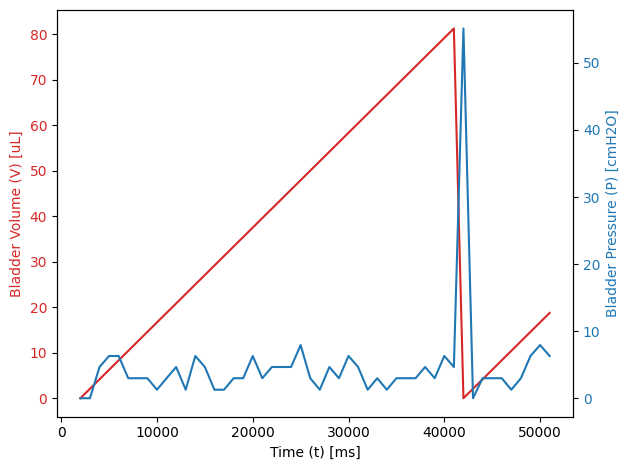

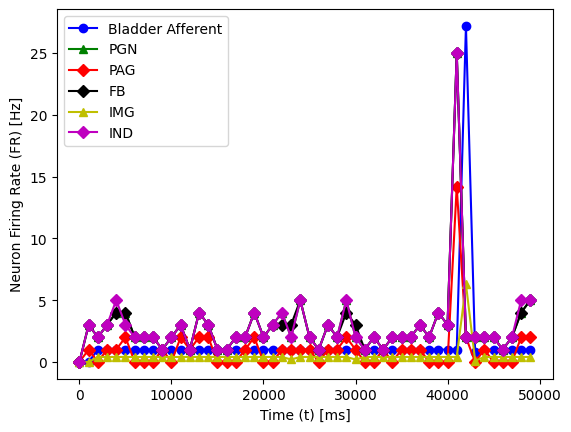

In [ ]:
import os, sys, logging, faulthandler
from bmtk.simulator import bionet
from bmtk.simulator.bionet.default_setters.cell_models import loadHOC
from bmtk.simulator.bionet.modules.sim_module import SimulatorMod
from bmtk.utils.reports.spike_trains import SpikeTrains
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.simulator.bionet.io_tools import io
import numpy as np
from neuron import h
import pandas as pd
# from bmtk.analyzer.cell_vars import plot_report
from feedback_loop import FeedbackLoop
from plotting import plot_figure, plotting_calculator
# Import the synaptic depression/facilitation model
import synapses

import plot_results


"""
Basic Logging features, disable faulthandler if you don't want stacktraces printed
logging determines the level and file to save logs to (might be worth moving location)
"""
faulthandler.enable()
logging.basicConfig(filename='error_logs/debug_run.log', level=logging.DEBUG)

synapses.load()
logging.info('Synapses Loaded')

press_thres = 17 #17 # cm H20 #40
                 # Lingala, et al. 2016
change_thres = 10 #10 # cm H20 #10
                 # Need biological value for this

bionet.pyfunction_cache.add_cell_model(loadHOC, directive='hoc', model_type='biophysical')
logging.info('Cell model added')

def run(config_file):

    conf = bionet.Config.from_json(config_file, validate=True)
    conf.build_env()

    fbmod = FeedbackLoop()

    graph = bionet.BioNetwork.from_config(conf)
    sim = bionet.BioSimulator.from_config(conf, network=graph)
    sim.add_mod(fbmod)  # Attach the above module to the simulator.
    sim.run()

    #fbmod.save_aff(conf.output_dir)
    plot_results.run(sim=sim,conf=conf)

# if __name__ == '__main__':
#     if __file__ != sys.argv[-1]:
#         run(sys.argv[-1])
#     else:
#         run('config.json')

run(config_file='jsons/simulation_config.json')